# Generating distribution maps of the chemical shifts in the BMRB protein NMR database

Author: Jonathan Bisson <bjo@uic.edu>

Licence: GNU GPL v3
    
You have to set PATH to a directory in which you downloaded http://www.bmrb.wisc.edu/ftp/pub/bmrb/relational_tables/nmr-star3.1/Atom_chem_shift.csv 

You need to have pandas, numpy, seaborn and matplotlib installed to be able to generate all the types of graphs

Thanks to the BMRB project:
"BioMagResBank", Eldon L. Ulrich; Hideo Akutsu; Jurgen F. Doreleijers; Yoko Harano; Yannis E. Ioannidis; Jundong Lin; Miron Livny; Steve Mading; Dimitri Maziuk; Zachary Miller; Eiichi Nakatani; Christopher F. Schulte; David E. Tolmie; R. Kent Wenger; Hongyang Yao; John L. Markley; Nucleic Acids Research 36, D402-D408 (2008) doi: 10.1093/nar/gkm957 

## Settings

In [1]:
# Set this to the path where http://www.bmrb.wisc.edu/ftp/pub/bmrb/relational_tables/nmr-star3.1/Atom_chem_shift.csv is stored
PATH = "../data/www.bmrb.wisc.edu/ftp/pub/bmrb/relational_tables/nmr-star3.1/"

## Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
%matplotlib inline

## Loading and preparing data

In [3]:
cs = pd.read_csv(PATH+'Atom_chem_shift.csv',
           usecols=['ID','Comp_ID', 'Atom_ID','Atom_type', 'Atom_isotope_number','Val','Val_err','Entry_ID'], engine='c')

In [4]:
grouped_entry = cs.groupby(['Entry_ID'])#,'Atom_ID'])
grouped_comp = cs.groupby(['Comp_ID'])#,'Atom_ID'])
grouped_comp_atom = cs.groupby(['Comp_ID','Atom_ID'])

In [5]:
def filter_percent(data, left=0.001, right=0.99999):
    """Filter the data to remove the outliers, we select values between /left/ and /right/ percentiles"""
    percentiles = [0.00001,0.0001,0.001,0.01,0.99,0.999,0.9999,0.99999]
    if left not in percentiles:
        raise ValueError('Left value must be in {}'.format(percentiles))
    if right not in percentiles:
        raise ValueError('Right value must be in {}'.format(percentiles))
    vals = dict(data.describe(percentiles=percentiles))
    
    return data[(data>
        vals['{0:f}'.format(100*left).rstrip('0')+'%']) & (data<vals['{0:f}'.format(100*right).rstrip('0')+'%'])]


In [6]:
bilan = [["AminoAcid","Proton","Mean","Std","Count","DataType"]]
for name,group in grouped_comp_atom:
    dat = filter_percent(group.Val).describe()
    bilan.append([name[0],name[1], dat['mean'], dat['std'], dat['count'] ,"Filtered at 0.001%-99.999% of the values"])

In [7]:
# Generating a common name 'aa_code'+'proton_code'
cs['mergedname'] = cs['Comp_ID'].map(str) + '-' + cs['Atom_ID'].map(str)

In [8]:
# We only want the common amino acids
stdamino = ['ALA', 'ARG', 'ASP', 'ASN', 'CYS', 
            'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 
            'LEU', 'LYS', 'MET', 'PHE', 'PRO', 
            'SER', 'THR', 'TRP', 'TYR', 'VAL']
data_h = cs[(cs.Atom_type=='H') & (cs.Comp_ID.isin(stdamino))]

In [9]:
# Select the biggest proteins
biggest_prots = grouped_entry.count().sort_values('Atom_ID', ascending=False)

In [10]:
# Removing the exchangables
forbiddenname = ['THR-HG1', 'SER-H', 'CYS-H', 'SER-HG', 'CYS-HG',
                'ASP-H', 'ASN-H', 'ASN-HD21', 'ASN-HD22',
                'GLU-H','GLN-H', 'GLN-HE21', 'GLN-HE22',
                'ARG-H', 'ARG-HE', 'ARG-H','GLY-H', 'TYR-HH',
                 'TRP-HE1', 'ARG-HH11', 'ARG-HH12', 'ARG-HH21', 'ARG-HH22',
                 'LYS-HZ1', 'LYS-HZ2', 'LYS-HZ3', 'PRO-H2', 'PRO-H3',
                 'ASP-HD2','GLU-HE2', 'HIS-HD1', 'HIS-HD2', 'HIS-HE1', 'HIS-HE2',
                'LYS-H','TRP-H','TYR-H', 'HIS-H']+[val+'-H' for val in stdamino]
                
data = data_h[(data_h.Entry_ID.isin(biggest_prots.index[0:200])) & 
          ~(data_h.mergedname.isin(forbiddenname))]


## Check the mean and std deviation of every proton

In [11]:
N = 10
df_all = pd.DataFrame(bilan[1:],columns=bilan[0])
df_all[df_all.Count>N]

,AminoAcid,Proton,Mean,Std,Count,DataType
7,0AZ,HA,4.617462,0.136053,13.0,Filtered at 0.001%-99.999% of the values
8,0AZ,HB2,2.261667,0.171177,12.0,Filtered at 0.001%-99.999% of the values
9,0AZ,HB3,2.041615,0.193685,13.0,Filtered at 0.001%-99.999% of the values
10,0AZ,HD22,3.762846,0.207835,13.0,Filtered at 0.001%-99.999% of the values
11,0AZ,HD23,3.694462,0.195536,13.0,Filtered at 0.001%-99.999% of the values
12,0AZ,HG,4.495167,0.195672,12.0,Filtered at 0.001%-99.999% of the values
31,0UH,H5',4.030000,0.122766,15.0,Filtered at 0.001%-99.999% of the values
812,8OG,H2',3.291489,0.092237,13.0,Filtered at 0.001%-99.999% of the values
813,8OG,H2'',2.413883,0.158867,13.0,Filtered at 0.001%-99.999% of the values
899,A,C1',91.606396,3.320239,952.0,Filtered at 0.001%-99.999% of the values


## Show the biggest proteins

In [12]:
biggest_prots

,ID,Comp_ID,Atom_ID,Atom_type,Atom_isotope_number,Val,Val_err,mergedname
Entry_ID,,,,,,,,
18857,21514,21514,21514,21514,21514,21514,21514,21514
30080,6416,6416,6416,6416,6416,6416,6416,6416
30086,5202,5202,5202,5202,5202,5202,5202,5202
4264,5105,5105,5105,5105,5105,5105,5105,5105
30081,5090,5090,5090,5090,5090,5090,5090,5090
30083,5078,5078,5078,5078,5078,5078,5078,5078
30084,5054,5054,5054,5054,5054,5054,5054,5054
16632,4978,4978,4978,4978,4978,4978,4978,4978
30082,4940,4940,4940,4940,4940,4940,4940,4940


## Plotting the distributions of each proton of each amino acid

In [13]:
def cond_dist_plot(val, *args,**kwargs):
    """A conditional dist plot that requires more than 1 value in the dataset"""
    if len(val)>1:
        try:
            return sns.distplot(val, *args,**kwargs)
        except ValueError:
            print(val)
    else:
        return None
def plot_all_cs_entry(entry_data):
    """Plot the distribution of all the atoms grouped by amino acid"""
    di = entry_data[ (entry_data.Atom_type=="H")]
    g = sns.FacetGrid(di, hue="Atom_ID", row='Comp_ID', margin_titles=True, sharey=False)
    
    g = g.map(cond_dist_plot,"Val",hist=False,  kde_kws={"shade": True}, norm_hist=True)
    g.set_axis_labels("Chemical shift (PPM)", "Density")
    plt.gca().invert_xaxis()

/home/bjo/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/bjo/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


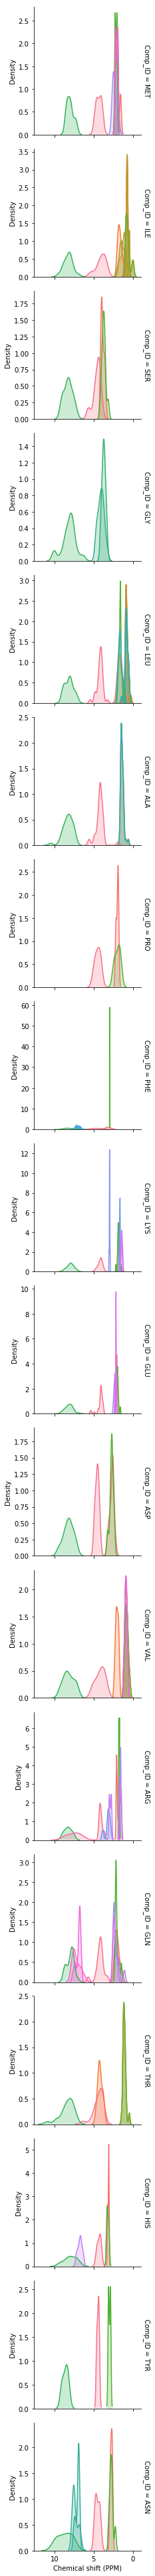

In [14]:
plot_all_cs_entry(grouped_entry.get_group(4264))

## How to access specific chemical shifts of a specific amino acid in a specific protein

In [15]:
ent = grouped_entry.get_group(4264)
ent[(ent.Comp_ID=='MET') & (ent.Atom_type=='H')].groupby('Atom_ID').Val.min()

Atom_ID
H      7.27
HA     4.00
HB2    2.04
HB3    1.58
HE1    1.94
HE2    1.94
HE3    1.94
HG2    2.46
HG3    1.94
Name: Val, dtype: float64

In [16]:
ent[(ent.Comp_ID=='MET') & (ent.Atom_type=='H')].groupby('Atom_ID').Val.max()

Atom_ID
H      8.46
HA     4.76
HB2    2.26
HB3    2.24
HE1    2.19
HE2    2.19
HE3    2.19
HG2    2.46
HG3    2.53
Name: Val, dtype: float64

## Violin plots of each proton in each selected amino acid
Set the amino acids and atoms you wish to see in *aminos_to_consider*


In [22]:
# We are only considering these amino acids for MET and GLY (some proteins have other designations)

aminos_to_consider = {
    'MET':['H', 'HA', 'HB2',
          'HB3', 'HE1','HG2',
          'HG3'],
    'GLY':['HA2', 'HA3']
}

/home/bjo/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


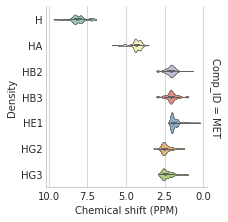

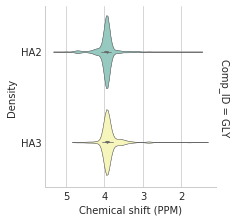

In [23]:
sns.set_style("whitegrid")
for amino in aminos_to_consider:
    selected = cs[(cs.Atom_type=='H') & (cs.Comp_ID==amino) & (cs.Entry_ID.isin(biggest_prots.index[0:20]))
             & (cs.Atom_ID.isin(aminos_to_consider[amino]))]
    
    g = sns.FacetGrid(selected, hue="Atom_ID", row='Comp_ID', margin_titles=True, sharey=False)
    g=g.map(sns.violinplot, y='Atom_ID', x='Val', data = selected, 
                   palette="Set3", bw=0.25, cut=1, linewidth=0.5,
                  orient='h')
    
    g.set_axis_labels("Chemical shift (PPM)", "Density")
    plt.gca().invert_xaxis()

## Plot the distribution of the different atoms in a single protein

We can now start having an idea of the distributions in a specific protein in a swarplot

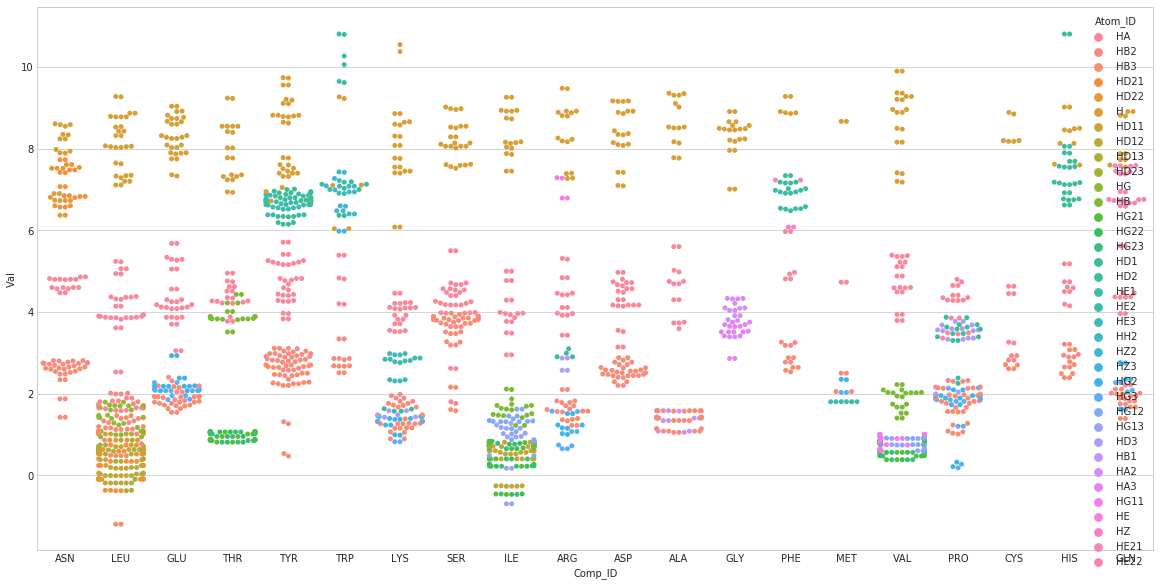

In [19]:
proteins_to_consider = biggest_prots.index[20:21]
plt.figure(figsize=(20,10))
sns.swarmplot(x='Comp_ID', y='Val', hue='Atom_ID', 
              data=cs[(cs.Atom_type=='H') & (cs.Entry_ID.isin(proteins_to_consider))])

## Generating the bar plots for each of the amino-acids and each of their signals

/home/bjo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1440x720 with 0 Axes>

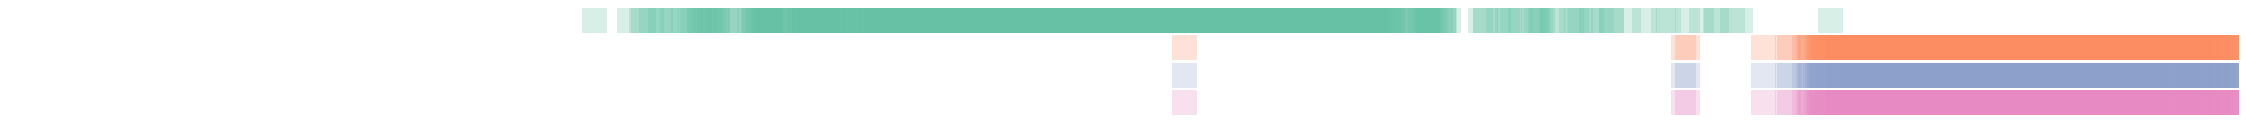

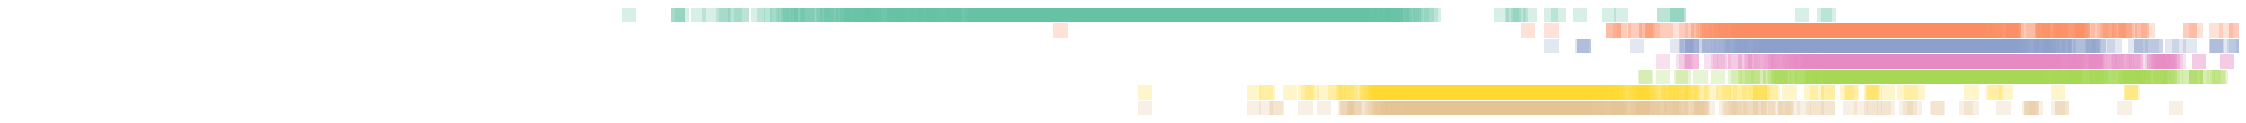

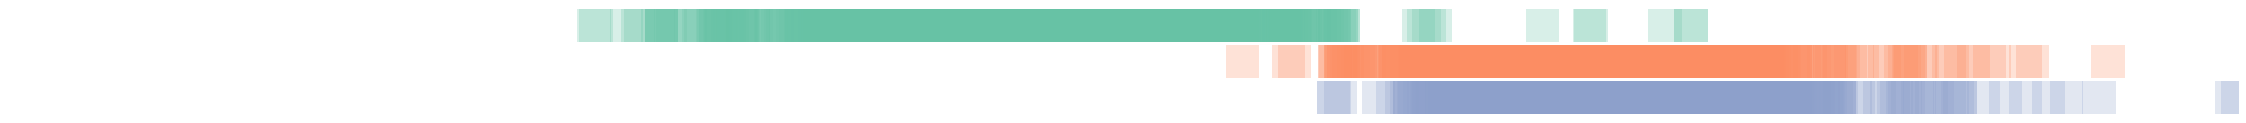

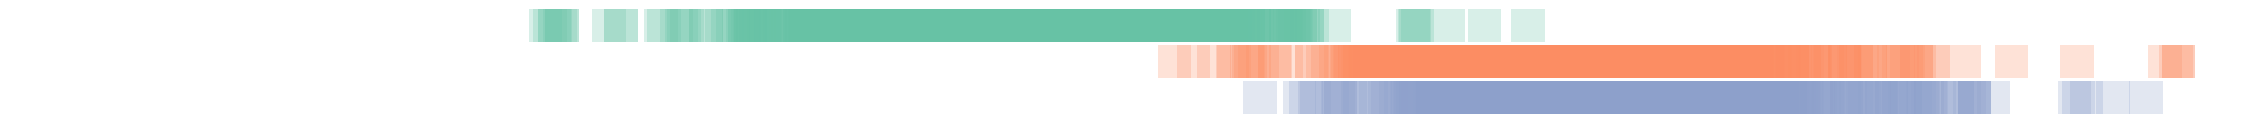

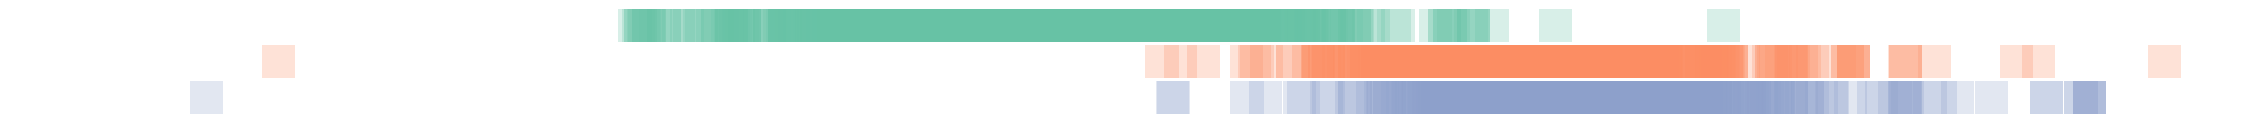

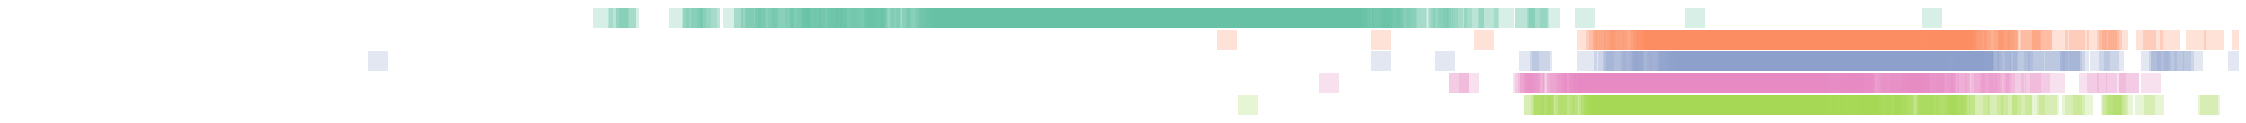

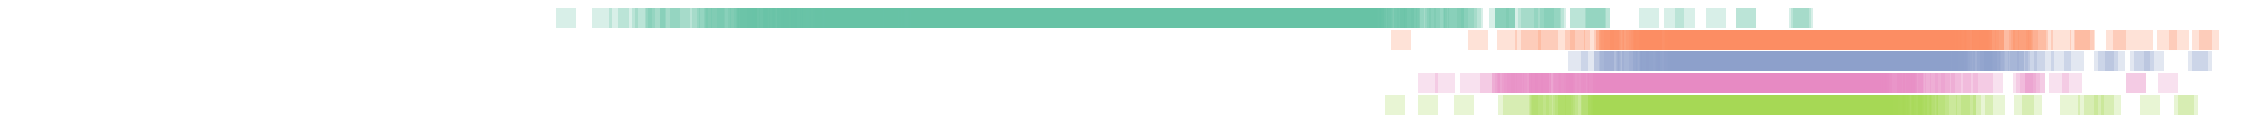

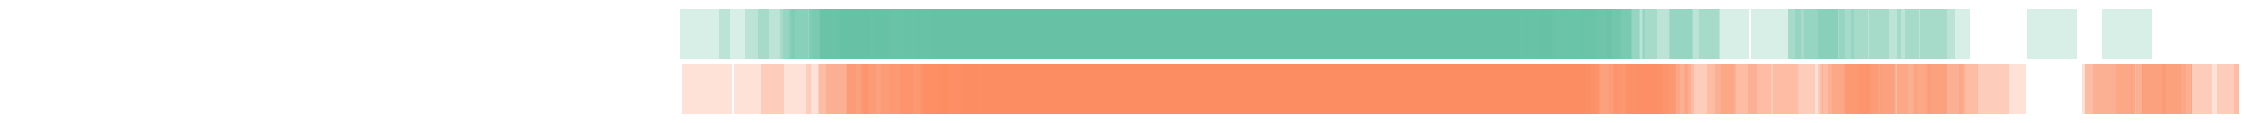

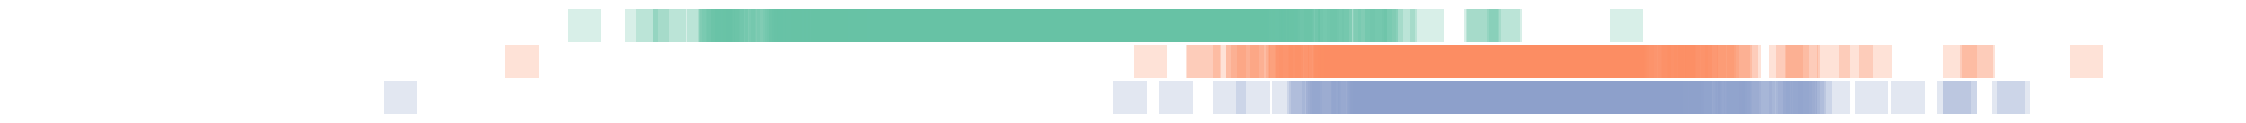

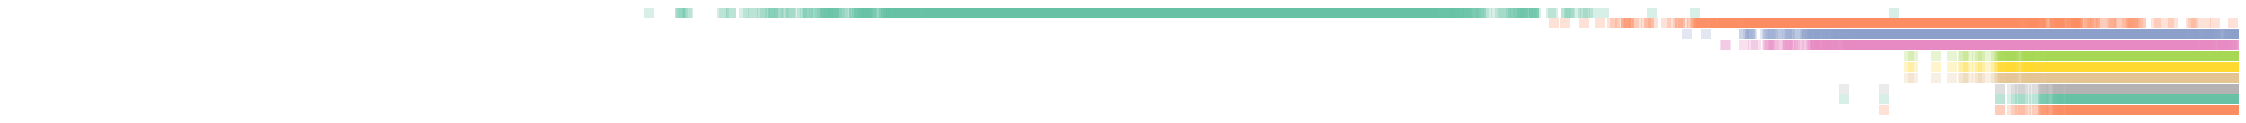

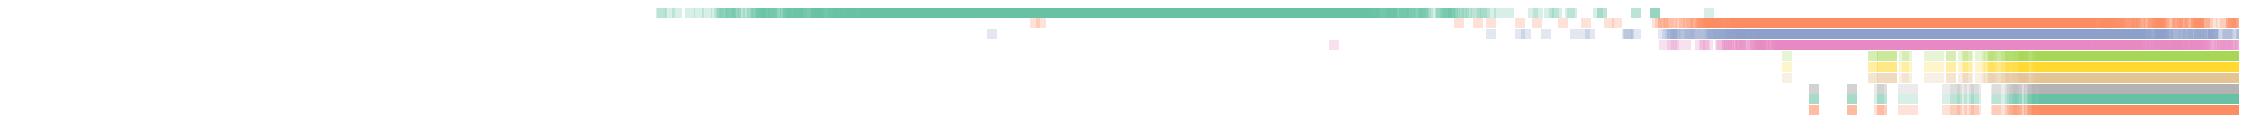

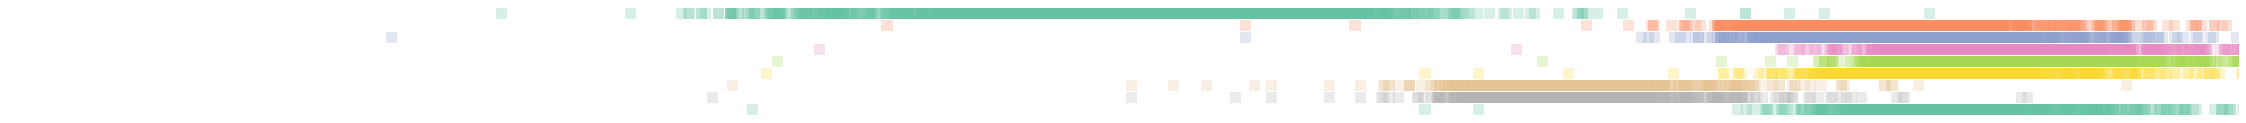

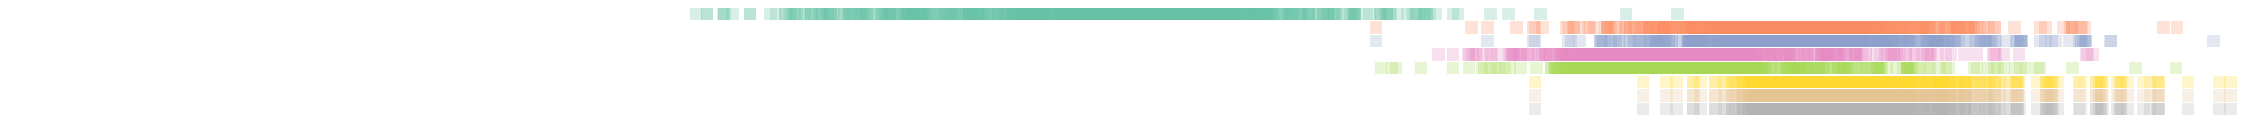

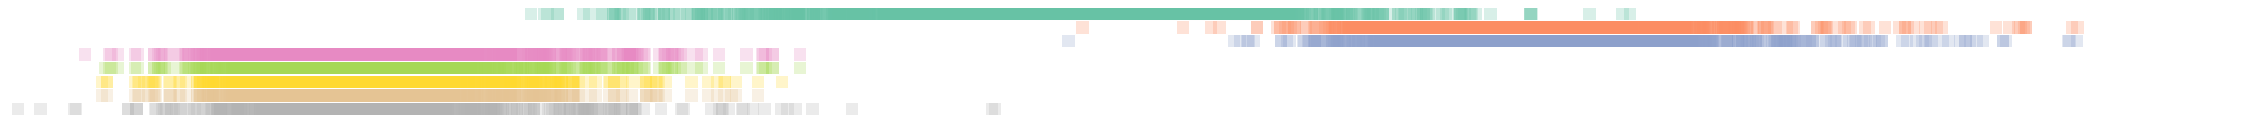

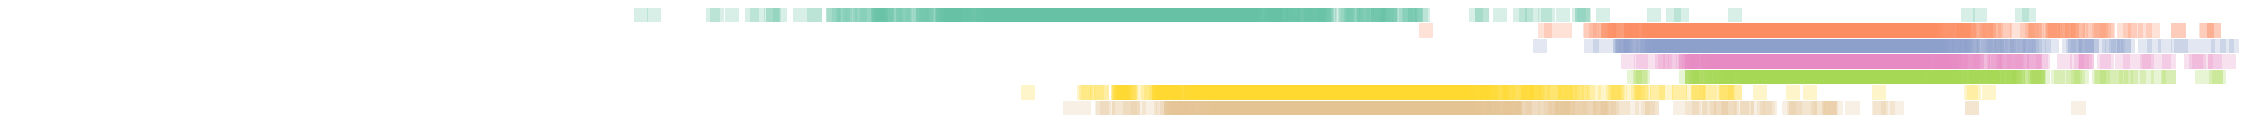

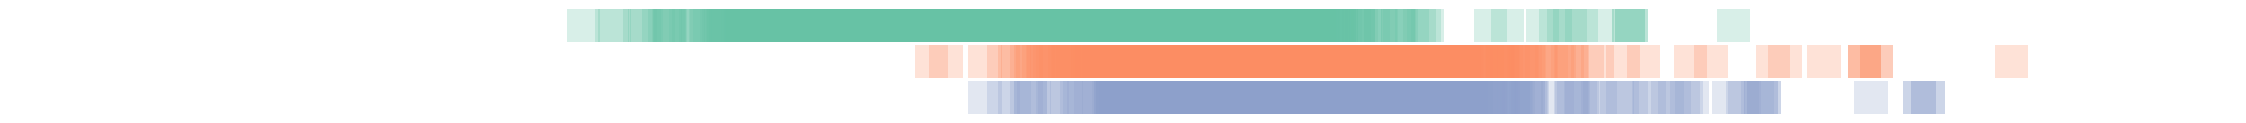

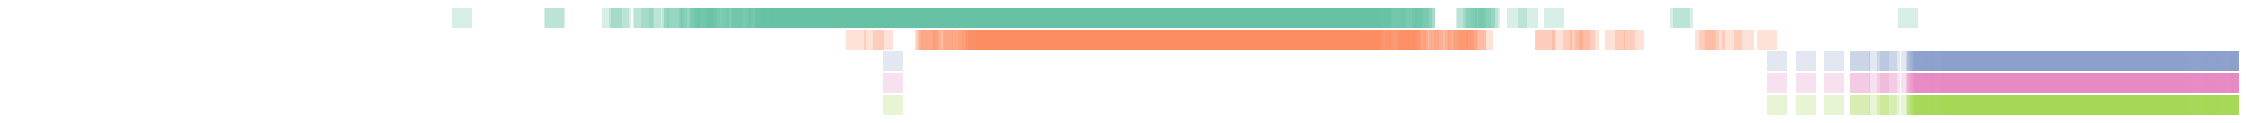

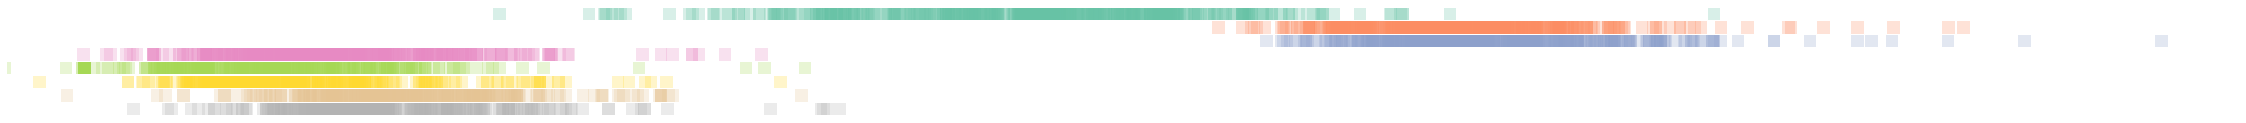

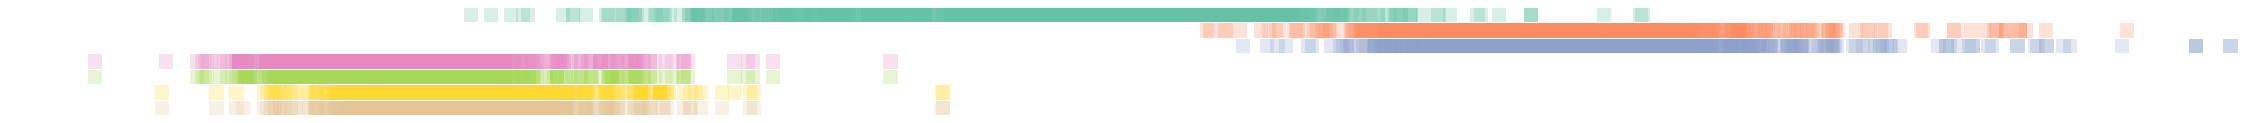

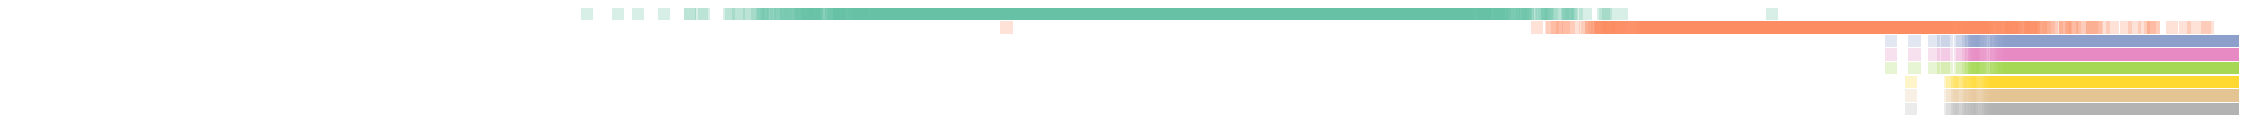

In [32]:
plt.figure(figsize=(20,10))

for amino in stdamino:
    fig=plt.figure(figsize=(40,2), frameon=False)
    seldata = data[data.Comp_ID==amino]
    ax=sns.stripplot('Val', 'Atom_ID', 'Atom_ID' ,
                        data=seldata,
                        palette="Set2", size=100/len(seldata.Atom_ID.drop_duplicates()), marker='s',
                         alpha=.25,
                        jitter=False,
                        dodge=False,
                     linewidth=0,
                       orient='h' )

    plt.gca().invert_xaxis()
    plt.xlim(8.25,0.5)
    ax.grid(False)
    ax.axis('off')
    ax.legend().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.patch.set_visible(False)

    plt.savefig('data/{}_distr_0_200_top_no_xch.png'.format(amino), transparent=True, bbox_inches='tight')